<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
#!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import string
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import re
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Google Drive

In [4]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in Data

In [76]:
df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
#df.dropna(axis=0, how='any', inplace=True)

# EDA

## Data observing

In [ ]:
df.shape

(568454, 10)

In [77]:
df = df.head(5000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5000 non-null   int64 
 1   ProductId               5000 non-null   object
 2   UserId                  5000 non-null   object
 3   ProfileName             5000 non-null   object
 4   HelpfulnessNumerator    5000 non-null   int64 
 5   HelpfulnessDenominator  5000 non-null   int64 
 6   Score                   5000 non-null   int64 
 7   Time                    5000 non-null   int64 
 8   Summary                 5000 non-null   object
 9   Text                    5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


In [ ]:
#df.isna().sum()

In [ ]:
#df.dropna(axis=0, inplace=True)
#df.isna().sum()

In [ ]:
#df.shape

In [ ]:
df.nunique()

Id                        5000
ProductId                  731
UserId                    4804
ProfileName               4689
HelpfulnessNumerator        44
HelpfulnessDenominator      47
Score                        5
Time                      1630
Summary                   4566
Text                      4984
dtype: int64

In [ ]:
df.columns.values.tolist()

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

In [23]:
duplicateRows = df[df.duplicated(['Text'])]
duplicateRows.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2946,2947,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,0,1,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


In [78]:
df.drop_duplicates(subset='Text', inplace = True)

In [ ]:
df.shape

(4984, 10)

In [ ]:
df[df.duplicated(['Text'])].sum()

Id                        0.0
ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
dtype: float64

In [79]:
df = df.drop(columns=['UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], axis=1)
df.head()

,Id,ProductId,Score,Summary,Text
0,1,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...


### Visualisation

In [ ]:
df['Score'].value_counts().sort_index()

1     467
2     287
3     393
4     711
5    3126
Name: Score, dtype: int64

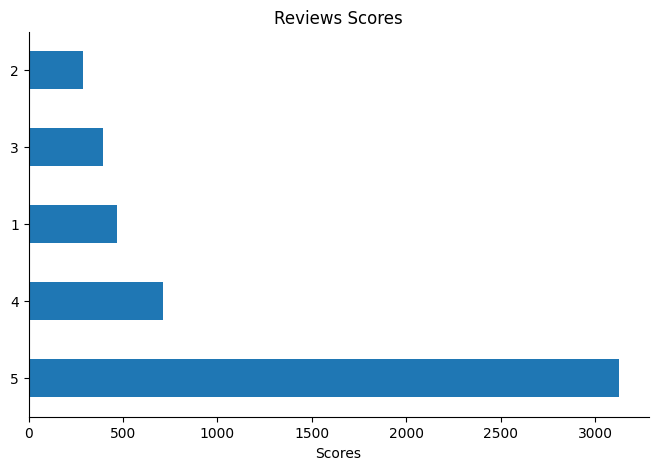

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df['Score'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Scores', 
          figsize=(8, 5))
plt.xlabel('Scores')
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scors_Bar.jpeg')
plt.show()

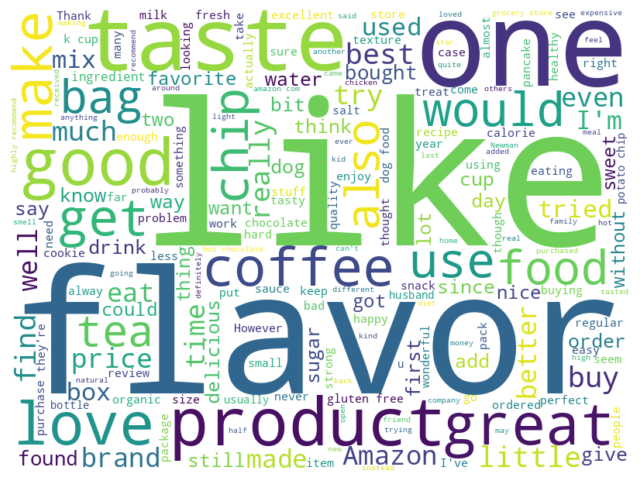

In [ ]:
# Create a word cloud of the 'Text' column
text = ' '.join(df['Text'].astype(str).tolist())
wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='white').generate(text) # stopwords=stopwords1
    
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/wordcloud_gen.jpeg')
plt.show()

## NLTK. Text preprocessing

In [9]:
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Stopwords

In [25]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [26]:
stopwords1 = set(stopwords.words('english'))

In [68]:
def df_preprocess(text):
    text = text.replace('br', ' ')
    text = text.replace('(a href)|(href)', ' ')
    text = re.sub('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]', '', text)
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords1])
    return text

In [38]:
df['Text'].iloc[25]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [69]:
df['Text'] = df['Text'].apply(df_preprocess)

In [31]:
df.head()

,Id,ProductId,Score,Summary,Text
0,1,B001E4KFG0,5,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,B00813GRG4,1,Not as Advertised,product arrived labeled jumbo salted peanuts.....
2,3,B000LQOCH0,4,"""Delight"" says it all","confection around centuries. light, pillowy ci..."
3,4,B000UA0QIQ,2,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,5,Great taffy,great taffy great price. wide assortment yummy...


In [70]:
df['Text'].iloc[25]

'product received advertised site strawberry 16ounce bag pack 6a'

### Lowercase 

! Just for example. Done above

In [ ]:
df['clean_text'] = df['Text'].str.lower()
df.head()

,Id,ProductId,Score,Summary,Text,clean_text
0,1,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,2,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,4,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...


### Remove punctuation and symbols

! Just for example. Done above
Noe convenient. Make 'http/https' 'br' impossible to delate from the text

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))

In [ ]:
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punctuations(x))
df.sample(10)

,Id,ProductId,Score,Summary,Text,clean_text
1149,1150,B004SR97LO,5,"Raw, Organic, Fair Trade, Tastes Great","Raw, Organic, Fair Trade, Tastes Great... What...",raw organic fair trade tastes great whats not ...
4806,4807,B00139TT72,4,Premium dog food,My 3 dogs love this food and are thriving on i...,my 3 dogs love this food and are thriving on i...
25,26,B001GVISJM,5,Twizzlers - Strawberry,Product received is as advertised.<br /><br />...,product received is as advertisedbr br a hrefh...
4162,4163,B004391DK0,5,great simple GF mix,After searching many local stores to find this...,after searching many local stores to find this...
947,948,B000ER6YO0,1,moms (and dads) beware of plastic in the food,I just wanted to post here that I found small ...,i just wanted to post here that i found small ...
2547,2548,B000ED9LDU,5,Fiber packed and nutrient rich,Flaxseed is a great way to get fiber in your d...,flaxseed is a great way to get fiber in your d...
4067,4068,B001EW5YQS,5,simply great,"Though this micpreamp has several weaknesses, ...",though this micpreamp has several weaknesses i...
2384,2385,B0089SPDUW,5,Yummy!,I love this coffee. Very dark but not at all b...,i love this coffee very dark but not at all bi...
4951,4952,B002RZ1QNG,5,Great Wine!,Just bottled this wine about 2 weeks ago. Ope...,just bottled this wine about 2 weeks ago open...
1414,1415,B001EO7GAI,5,All hail the Israelis!,Because they brought bagels to America without...,because they brought bagels to america without...


In [ ]:
df['Text'].iloc[25]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [ ]:
df['clean_text'].iloc[25]

'product received is as advertisedbr br a hrefhttpwwwamazoncomgpproductb001gvisjmtwizzlers strawberry 16ounce bags pack of 6a'

### Tokenize

In [ ]:
df['Text'].iloc[15]

"My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers."

In [80]:
tokens = nltk.word_tokenize(df['Text'].iloc[15])
tokens

['My',
 'daughter',
 'loves',
 'twizzlers',
 'and',
 'this',
 'shipment',
 'of',
 'six',
 'pounds',
 'really',
 'hit',
 'the',
 'spot',
 '.',
 'It',
 "'s",
 'exactly',
 'what',
 'you',
 'would',
 'expect',
 '...',
 'six',
 'packages',
 'of',
 'strawberry',
 'twizzlers',
 '.']

In [81]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('My', 'PRP$'),
 ('daughter', 'NN'),
 ('loves', 'VBZ'),
 ('twizzlers', 'NNS'),
 ('and', 'CC'),
 ('this', 'DT'),
 ('shipment', 'NN'),
 ('of', 'IN'),
 ('six', 'CD'),
 ('pounds', 'NNS')]

In [71]:
nltk_pos = pd.read_excel('/content/drive/MyDrive/DS/ВКР/NLP/NLTK_pos_tags.xlsx')
nltk_pos

,Abbreviation,Meaning
0,CC,coordinating conjunction
1,CD,cardinal digit
2,DT,determiner
3,EX,existential there
4,FW,foreign word
5,IN,preposition/subordinating conjunction
6,JJ,This NLTK POS Tag is an adjective (large)
7,JJR,"adjective, comparative (larger)"
8,JJS,"adjective, superlative (largest)"
9,LS,list market


In [82]:
# Identify POS of words
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  My/PRP$
  daughter/NN
  loves/VBZ
  twizzlers/NNS
  and/CC
  this/DT
  shipment/NN
  of/IN
  six/CD
  pounds/NNS
  really/RB
  hit/VBD
  the/DT
  spot/NN
  ./.
  It/PRP
  's/VBZ
  exactly/RB
  what/WP
  you/PRP
  would/MD
  expect/VB
  .../:
  six/CD
  packages/NNS
  of/IN
  strawberry/NN
  twizzlers/NNS
  ./.)


# Tweets classification

## VADER 

( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:<br>
Stop words are removed<br>
each word is scored and combined to a total score.

In [ ]:
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('Live long and prosper!')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
sia.polarity_scores('burn in hell!')

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.7088}

In [ ]:
example1 = df['Text'].iloc[30]
example1

'This offer is a great price and a great taste, thanks Amazon for selling this product.<br /><br />Staral'

In [ ]:
sia.polarity_scores(example1)

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.9153}

In [ ]:
example2 = df['Text'].iloc[60]
example2

'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy'

In [ ]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}

In [ ]:
# Run the polarity score on the entire dataset
res_vader = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    df_id = row['Id']
    res_vader[df_id] = sia.polarity_scores(text)

  0%|          | 0/4984 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res_vader)

In [ ]:
vaders.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
neg,0.0000,0.1380,0.0910,0.0,0.0000,0.029,0.0340,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.1150,0.0000,0.080,0.0250,0.0260,0.0970,0.1540,0.0000
neu,0.6950,0.8620,0.7540,1.0,0.5520,0.809,0.6930,0.5200,0.8510,0.7050,...,0.5650,0.8180,0.8480,0.6790,0.692,0.8830,0.7640,0.8270,0.6370,0.7170
pos,0.3050,0.0000,0.1550,0.0,0.4480,0.163,0.2730,0.4800,0.1490,0.2950,...,0.4350,0.1820,0.0370,0.3210,0.228,0.0920,0.2100,0.0760,0.2090,0.2830
compound,0.9441,-0.5664,0.8265,0.0,0.9468,0.883,0.9346,0.9487,0.6369,0.8313,...,0.9531,0.7177,-0.8264,0.9693,0.792,0.7193,0.9846,-0.0554,0.9078,0.9923


In [ ]:
vaders = vaders.T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### VADER results visualisation

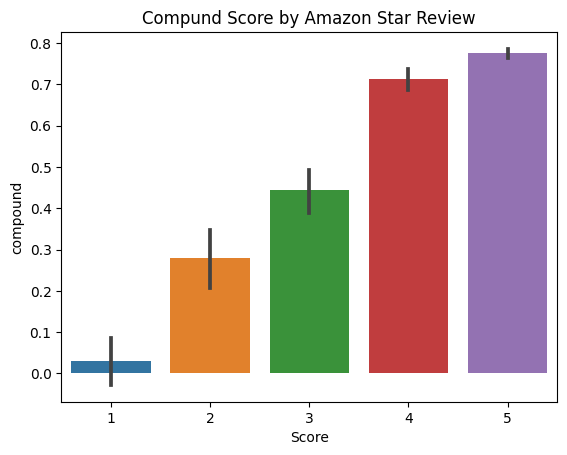

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Compund Score by Amazon Star Review.jpeg')
plt.show()

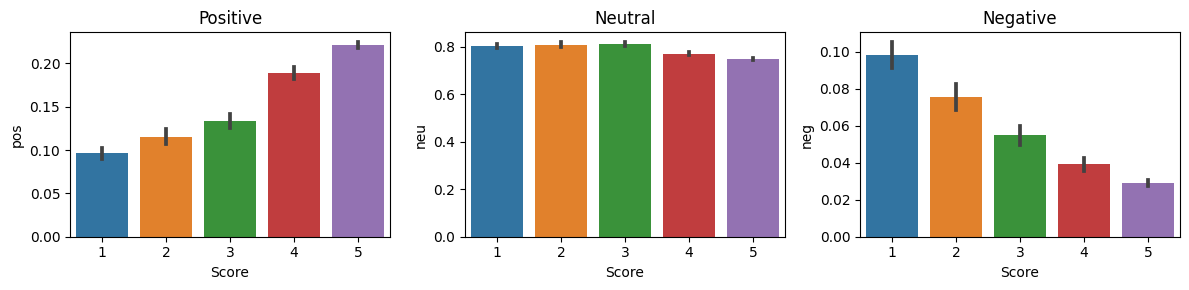

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scores by Amazon Star Review.jpeg')
plt.show()

## Roberta Pretrained Model

Use a model trained of a large corpus of data.

Transformer model accounts for the words but also the context related to other words.

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = df['Text'].iloc[0]
example

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.009624243, 'roberta_neu': 0.049980447, 'roberta_pos': 0.9403953}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res_roberta = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        df_id = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res_roberta[df_id] = both
    except RuntimeError:
        print(f'Broke for id {df_id}')

  0%|          | 0/4984 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583


In [ ]:
results_df = pd.DataFrame(res_roberta)
results_df.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
vader_neg,0.000000,0.138000,0.091000,0.000000,0.000000,0.02900,0.034000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.115000,0.000000,0.080000,0.025000,0.026000,0.097000,0.154000,0.000000
vader_neu,0.695000,0.862000,0.754000,1.000000,0.552000,0.80900,0.693000,0.520000,0.851000,0.705000,...,0.565000,0.818000,0.848000,0.679000,0.692000,0.883000,0.764000,0.827000,0.637000,0.717000
vader_pos,0.305000,0.000000,0.155000,0.000000,0.448000,0.16300,0.273000,0.480000,0.149000,0.295000,...,0.435000,0.182000,0.037000,0.321000,0.228000,0.092000,0.210000,0.076000,0.209000,0.283000
vader_compound,0.944100,-0.566400,0.826500,0.000000,0.946800,0.88300,0.934600,0.948700,0.636900,0.831300,...,0.953100,0.717700,-0.826400,0.969300,0.792000,0.719300,0.984600,-0.055400,0.907800,0.992300
roberta_neg,0.009624,0.508986,0.003229,0.002295,0.001635,0.00613,0.001305,0.002029,0.003874,0.003103,...,0.001691,0.007842,0.905936,0.001312,0.133682,0.100337,0.019922,0.602979,0.011522,0.009068


In [ ]:
results_df = results_df.T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare Scores between models

In [ ]:
results_df.columns.to_list()

['Id',
 'vader_neg',
 'vader_neu',
 'vader_pos',
 'vader_compound',
 'roberta_neg',
 'roberta_neu',
 'roberta_pos',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

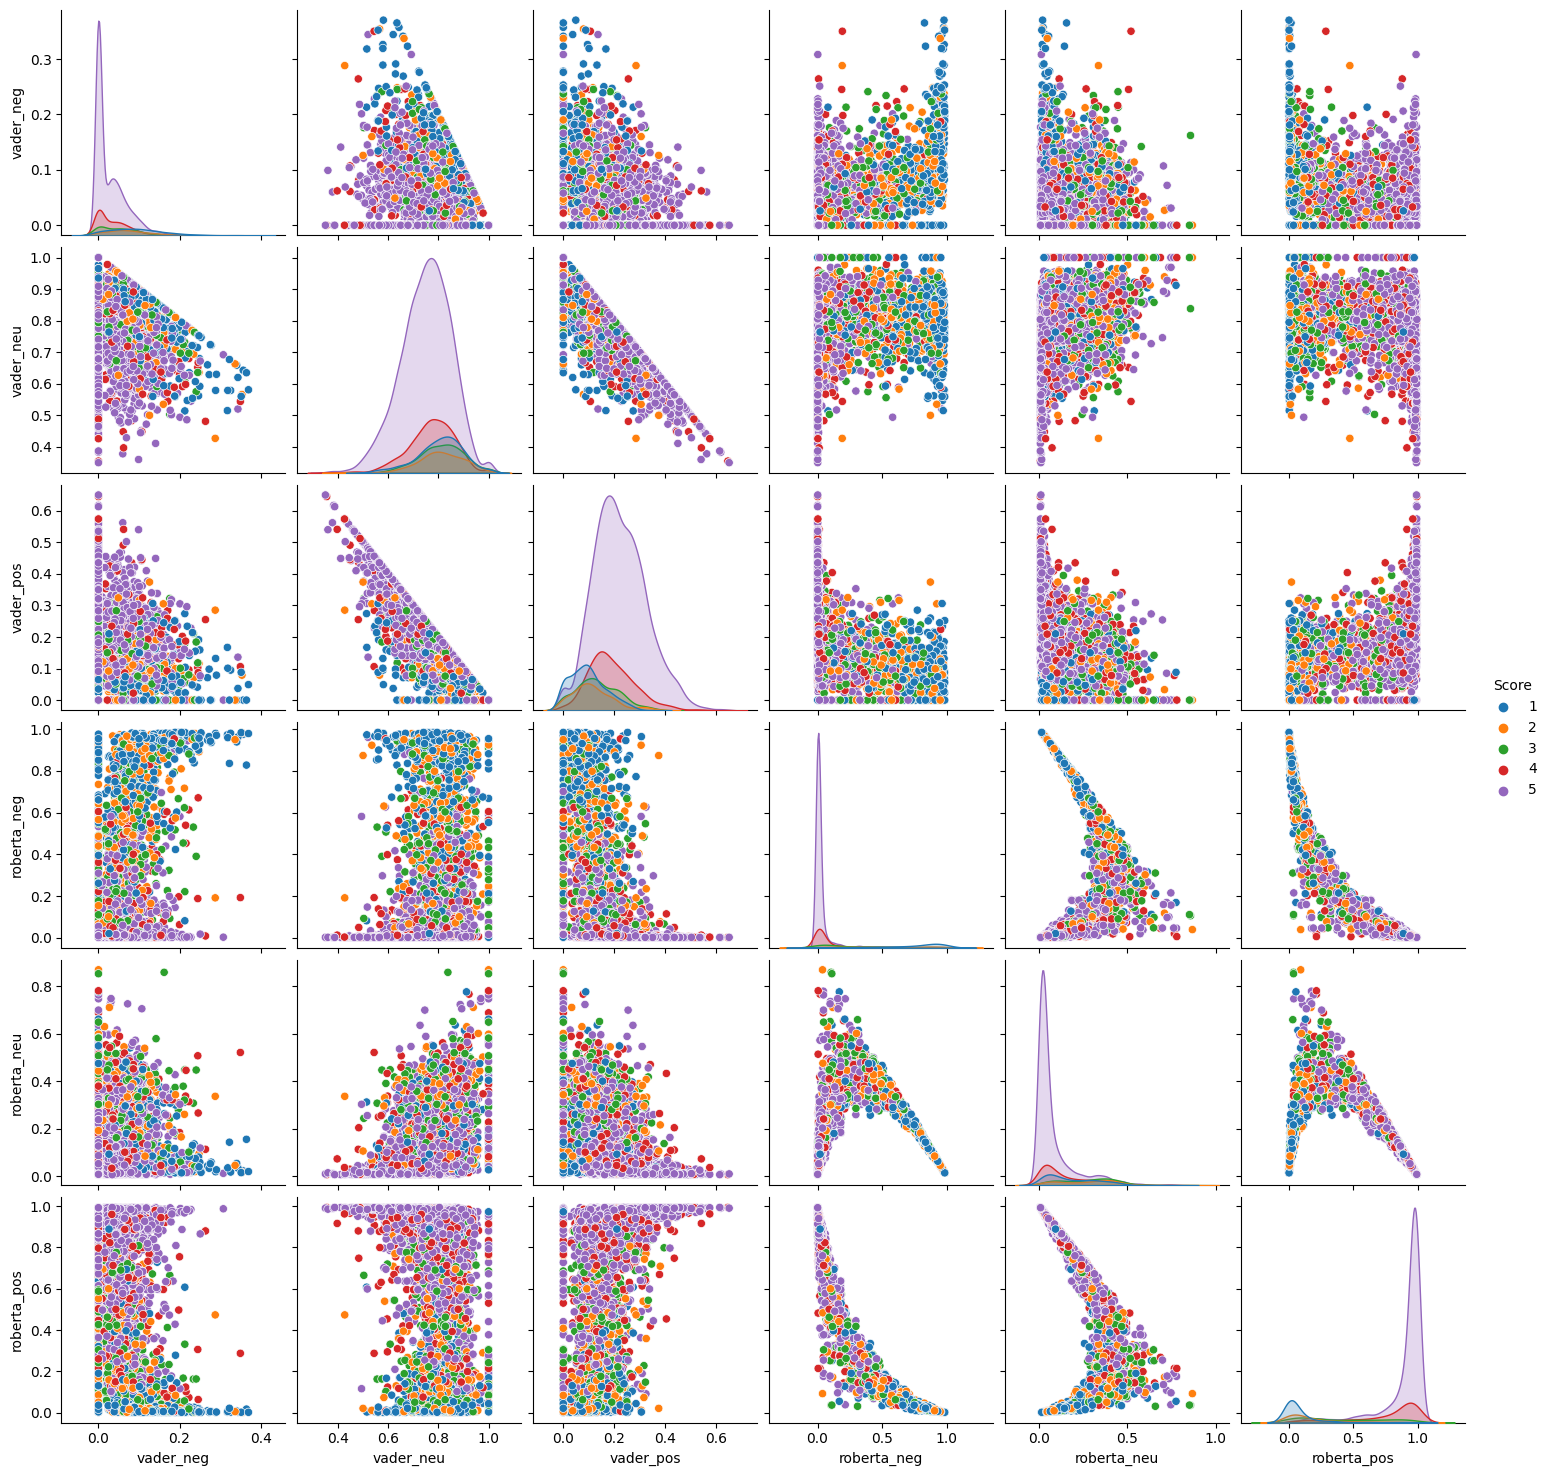

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Vader_Roberta_comparison.jpeg')
plt.show()

## Loss examples
Lets look at some examples where the model scoring and review score differ the most.

Positive 1-Star and Negative 5-Star Reviews

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[5]

'This has to be without a doubt the WORST tasting Hot Chocolate ever! The best way to describe the taste of "This Stuff" is really cheap suger free instant hot chocolate. Swiss Miss instant is way better and cost less. After only 3 cups threw the rest in the garbage where it belongs and canceled my subscribe and save for this "SLOP"!'

# ЧЕРНОВИК

## r score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(data['polarity'], data['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(data['polarity'], data['vader_prediction']))